## Read the file including the umbrella sampling file indices and parameters, like force constants, window center, etc

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma

# import some functions which should not clutter the notebook
#import shortcuts

# figure size parameters
pw = 6
ph = 0.75 * pw

In [2]:
# load biased data
us_data_path = "/media/yibo/data/mor/tram/um/"
# usually called as meta file
us_meta = np.loadtxt(us_data_path + "meta.dat")
# obtain the biased simulation parameters from the meta.dat file:  file_name, win_center, force _constants
us_umbrella_centers = us_meta[:,1].copy()
us_force_constants = us_meta[:,2].copy()
#load CV (distance between ION and the reference position)
us_trajs = [np.loadtxt(us_data_path + "um-%d.dat" % i).reshape((-1,1)).copy() for i in us_meta[:,0]]

In [4]:
# load unbiased data
md_data_path = "/media/yibo/data/mor/tram/md/"
# load unbiased data
md_trajs = [np.loadtxt(md_data_path + "md-%d.dat" % i).reshape((-1, 1)).copy() for i in range(26,95)]

In [5]:
us_cluster = pyemma.coordinates.cluster_regspace(us_trajs + md_trajs, max_centers=500, dmin=0.5)
# split dtrajs into biased and unbiased
us_dtrajs = us_cluster.dtrajs[:len(us_trajs)]
md_dtrajs = us_cluster.dtrajs[len(us_trajs):]

Regular space clustering: Cluster generators were chosen to be approximately equally separated in RMSD: a minimal distance dmin was fixed, the first trajectory frame was used as the first cluster center, then the trajectory was iterated and a frame was accepted as cluster center when its RMSD to all existing cluster centers was equal or greater than dmin.

In [ ]:
lags = [1, 10, 20, 50, 100, 200, 500]
objs = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_umbrella_centers.tolist(), us_force_constants.tolist(), kT=0.616,
    md_trajs=md_trajs, md_dtrajs=md_dtrajs,
    maxiter=100000, maxerr=1.0E-4, save_convergence_info=10, estimator='dtram', lag=lags)

## run WHAM and dTRAM for only umbrella sampling data; plot the convergence info and the free energies

In [7]:
lags = [1, 10, 20, 50, 100, 200, 500]
us_wham = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_umbrella_centers.tolist(), us_force_constants.tolist(), kT=0.616,
    maxiter=100000, maxerr=1.0E-4, save_convergence_info=50, estimator='wham')
us_dtram = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_umbrella_centers.tolist(), us_force_constants.tolist(), kT=0.616,
    maxiter=100000, maxerr=1.0E-4, save_convergence_info=50, estimator='dtram', lag=lags)


In [8]:
[ m.name for m in us_dtram ]

['pyemma.thermo.estimators.DTRAM_estimator.DTRAM[1]',
 'pyemma.thermo.estimators.DTRAM_estimator.DTRAM[2]',
 'pyemma.thermo.estimators.DTRAM_estimator.DTRAM[3]',
 'pyemma.thermo.estimators.DTRAM_estimator.DTRAM[4]',
 'pyemma.thermo.estimators.DTRAM_estimator.DTRAM[5]',
 'pyemma.thermo.estimators.DTRAM_estimator.DTRAM[6]',
 'pyemma.thermo.estimators.DTRAM_estimator.DTRAM[7]']

[]

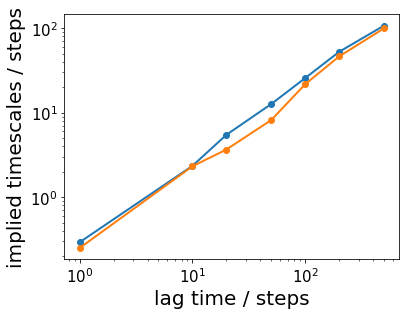

In [21]:
its = np.array([dtram.models[-1].timescales(2) for dtram in us_dtram])
fig, ax = plt.subplots(1, 1, figsize=(pw, ph))
for i in range(2):
    ax.plot(lags, its[:, i], '-o', linewidth=2)
ax.set_xlabel(r"lag time / steps", fontsize=20)
ax.set_ylabel(r"implied timescales / steps", fontsize=20)
ax.tick_params(labelsize=15)
ax.semilogx()
ax.semilogy()

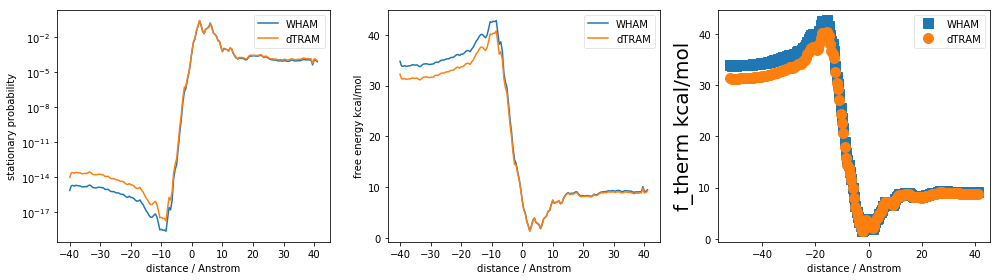

In [42]:
fig, axes = plt.subplots(1,3, figsize=(14, 4))
axes[0].plot(us_umbrella_centers[us_wham.active_set], us_wham.pi, label='WHAM')
axes[0].plot(us_umbrella_centers[us_dtram[-1].active_set], us_dtram[-1].pi, label='dTRAM')
axes[0].semilogy()
axes[0].set_ylabel('stationary probability')
axes[1].plot(us_umbrella_centers[us_wham.active_set], us_wham.f, label='WHAM')
axes[1].plot(us_umbrella_centers[us_dtram[-1].active_set], us_dtram[-1].f, label='dTRAM')
axes[1].set_ylabel('free energy kcal/mol')
axes[2].plot(us_wham.umbrella_centers[:, 0], us_wham.f_therm, 's', markersize=10, label='WHAM')
axes[2].plot(us_dtram[-1].umbrella_centers[:, 0], us_dtram[-1].f_therm, 'o', markersize=10, label='dTRAM')
axes[2].set_ylabel(r"f_therm kcal/mol", fontsize=20)
for ax in axes.flat:
    ax.set_xlabel('distance / Anstrom')
    ax.legend(fancybox=True, framealpha=0.5)
fig.tight_layout()

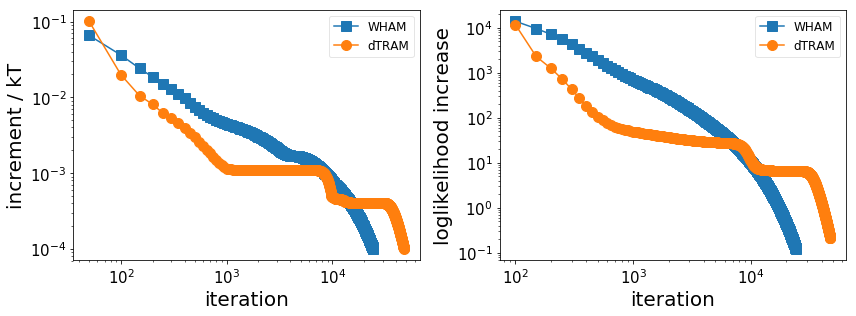

In [44]:
# plot the convergence info
fig, ax = plt.subplots(1, 2, figsize=(2 * pw, ph))
ax[0].plot(
    (np.arange(us_wham.increments.shape[0]) + 1) * us_wham.save_convergence_info,
    us_wham.increments, '-s', markersize=10, label='WHAM')
ax[0].plot(
    (np.arange(us_dtram[-1].increments.shape[0]) + 1) * us_dtram[-1].save_convergence_info,
    us_dtram[-1].increments, '-o', markersize=10, label='dTRAM')
ax[0].set_ylabel(r"increment / kT", fontsize=20)
ax[1].plot(
    (np.arange(1, us_wham.loglikelihoods.shape[0]) + 1) * us_wham.save_convergence_info,
    us_wham.loglikelihoods[1:] - us_wham.loglikelihoods[:-1], '-s', markersize=10, label='WHAM')
ax[1].plot(
    (np.arange(1, us_dtram[-1].loglikelihoods.shape[0]) + 1) * us_dtram[-1].save_convergence_info,
    us_dtram[-1].loglikelihoods[1:] - us_dtram[-1].loglikelihoods[:-1], '-o', markersize=10, label='dTRAM')
ax[1].set_ylabel(r"loglikelihood increase", fontsize=20)
for _ax in ax:
    _ax.set_xlabel(r"iteration", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.semilogx()
    _ax.semilogy()
    _ax.legend(loc=1, fontsize=12, fancybox=True, framealpha=0.5)
fig.tight_layout()

In [51]:
from glob import glob

### f_therm:free energies at the different thermodynamic states

## run both estimators again for biased and unbiased data; plot convergence info and free energies; run PCCA on the unbiased MSM and compute the mean first passage times

In [45]:
lags = [1, 5, 10, 50, 100, 200, 500]
us_wham2 = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_umbrella_centers.tolist(), us_force_constants.tolist(), kT=0.616,
    md_trajs=md_trajs, md_dtrajs=md_dtrajs,
    maxiter=100000, maxerr=1.0E-4, save_convergence_info=10, estimator='wham')
us_dtram2 = pyemma.thermo.estimate_umbrella_sampling(
    us_trajs, us_dtrajs, us_umbrella_centers.tolist(), us_force_constants.tolist(), kT=0.616,
    md_trajs=md_trajs, md_dtrajs=md_dtrajs,
    maxiter=100000, maxerr=1.0E-4, save_convergence_info=10, estimator='dtram', lag=lags) 



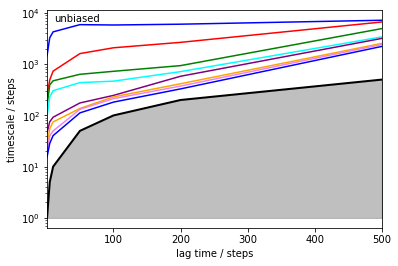

In [47]:
pyemma.plots.plot_memm_implied_timescales(us_dtram2, nits=8)

choose lagtime = 50 (*2 ps) which is "us_dtram[-4]"

In [83]:
print(us_dtram2[-4].lag)

50


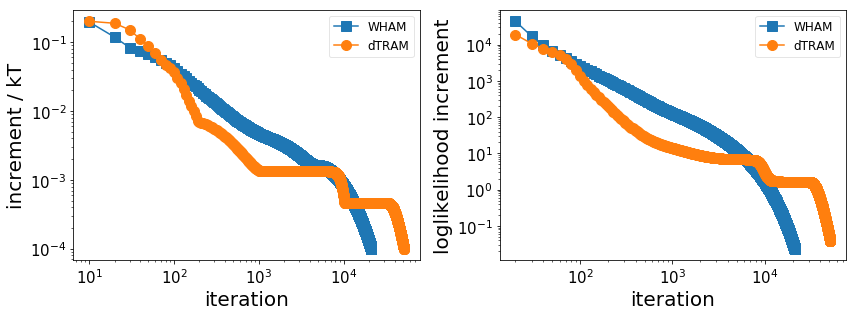

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(2 * pw, ph))
ax[0].plot(
    (np.arange(us_wham2.increments.shape[0]) + 1) * us_wham2.save_convergence_info,
    us_wham2.increments, '-s', markersize=10, label='WHAM')
ax[0].plot(
    (np.arange(us_dtram2[-4].increments.shape[0]) + 1) * us_dtram2[-4].save_convergence_info,
    us_dtram2[-4].increments, '-o', markersize=10, label='dTRAM')
ax[0].set_ylabel(r"increment / kT", fontsize=20)
ax[1].plot(
    (np.arange(1, us_wham2.loglikelihoods.shape[0]) + 1) * us_wham2.save_convergence_info,
    us_wham2.loglikelihoods[1:] - us_wham2.loglikelihoods[:-1], '-s', markersize=10, label='WHAM')
ax[1].plot(
    (np.arange(1, us_dtram2[-4].loglikelihoods.shape[0]) + 1) * us_dtram2[-4].save_convergence_info,
    us_dtram2[-4].loglikelihoods[1:] - us_dtram2[-4].loglikelihoods[:-1], '-o', markersize=10, label='dTRAM')
ax[1].set_ylabel(r"loglikelihood increment", fontsize=20)
for _ax in ax:
    _ax.set_xlabel(r"iteration", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.semilogx()
    _ax.semilogy()
    _ax.legend(loc=1, fontsize=12, fancybox=True, framealpha=0.5)
fig.tight_layout()

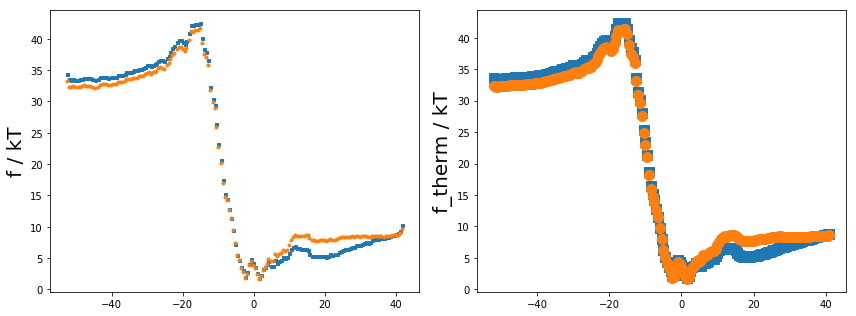

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(2 * pw, ph))
ax[0].plot(
    us_cluster.clustercenters[us_wham2.active_set, 0], us_wham2.f, 's', markersize=3, label='WHAM')
ax[0].plot(
    us_cluster.clustercenters[us_dtram2[-4].active_set, 0], us_dtram2[-4].f, 'o', markersize=3, label='dTRAM')
ax[0].set_ylabel(r"f / kT", fontsize=20)
ax[1].plot(us_wham2.umbrella_centers[:-1, 0], us_wham2.f_therm[:-1], 's', markersize=10, label='WHAM')
ax[1].plot(us_dtram2[-4].umbrella_centers[:-1, 0], us_dtram2[-4].f_therm[:-1], 'o', markersize=10, label='dTRAM')
ax[1].set_ylabel(r"f_therm / kT", fontsize=20)

for ax in axes.flat:
    ax.set_xlabel('distance / Anstrom')
    ax.legend(fancybox=True, framealpha=0.5)
fig.tight_layout()

In [85]:
dtram_kin = us_dtram2[-4]

In [93]:
pcca = dtram_kin.msm.pcca(5)

(-10, 41)

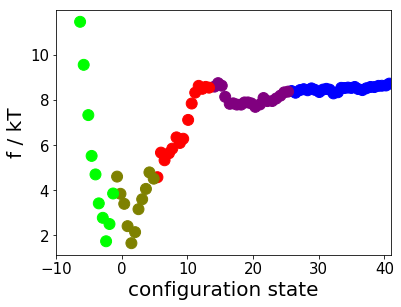

In [94]:
fig, ax = plt.subplots(figsize=(pw, ph))

ax.scatter(
    us_cluster.clustercenters[dtram_kin.msm.active_set, 0],
    -np.log(dtram_kin.msm.stationary_distribution),
    s=120, c=pcca.metastable_assignment, cmap=mpl.cm.brg)
ax.set_xlabel(r"configuration state", fontsize=20)
ax.set_ylabel(r"f / kT", fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xlim([-10, 41])

In [98]:
print('MFPT[blue->purple): %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[0], pcca.metastable_sets[1]))
print('MFPT[purple->blue]: %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[1], pcca.metastable_sets[0]))
print('MFPT[purple->red): %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[1], pcca.metastable_sets[2]))
print('MFPT[red->purple]: %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[2], pcca.metastable_sets[1]))
print('MFPT[red->brown): %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[2], pcca.metastable_sets[3]))
print('MFPT[brown->red]: %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[3], pcca.metastable_sets[2]))
print('MFPT[brown->green): %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[3], pcca.metastable_sets[4]))
print('MFPT[green->brow]: %.0f steps ' % dtram_kin.msm.mfpt(pcca.metastable_sets[4], pcca.metastable_sets[3]))

MFPT[blue->purple): 723 steps 
MFPT[purple->blue]: 182000 steps 
MFPT[purple->red): 3526 steps 
MFPT[red->purple]: 265220 steps 
MFPT[red->brown): 701 steps 
MFPT[brown->red]: 14594 steps 
MFPT[brown->green): 3908 steps 
MFPT[green->brow]: 2001 steps 


dtram_state_1 = [i for i, s in enumerate(us_dtram2.active_set) if us_umbrella_centers.tolist()[s] > 17.5]
dtram_state_2 = [i for i, s in enumerate(us_dtram2.active_set) if 8.5 < us_umbrella_centers.tolist()[s] < 17.5]
dtram_state_3 = [i for i, s in enumerate(us_dtram2.active_set) if 4.0 < us_umbrella_centers.tolist()[s] > 8.5]
dtram_state_4 = [i for i, s in enumerate(us_dtram2.active_set) if -8.5 < us_umbrella_centers.tolist()[s] < 4.0]
dtram_state_5 = [i for i, s in enumerate(us_dtram2.active_set) if us_umbrella_centers.tolist()[s] < -8.5]


In [96]:
np.savetxt('test.out',us_dtram2.f)
np.savetxt('test1.out',us_umbrella_centers.tolist())
